In [1]:
# from keras import models
# from keras import layers
# from keras.preprocessing.text import Tokenizer
# encoder_sequences = tokenizer.texts_to_sequences(encoder_text)

# network = models.Sequential()
# network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
# network.add(layers.Dense(10, activation='softmax'))

Using TensorFlow backend.


In [ ]:
# e.g: ["Hi", "Hello", "How are you"]
# to_sequence: {'hi': 1, 'hello': 2, 'how': 3, 'are':4, 'you': 5}
# Hi           -> to_sequence -> [1]       -> padding -> [0, 0, 1]
# Hello        -> to_sequence -> [2]       -> padding -> [0, 0, 2]
# How are you  -> to_sequence-> [3, 4, 5]  -> padding -> [3, 4, 5]

In [47]:
from keras               import layers
from keras               import utils

from keras.models        import Sequential
from keras.layers        import Dense, Activation, Dropout
from keras.optimizers    import SGD

from nltk.stem           import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer

import numpy             as np
import matplotlib.pyplot as plt

import random
import nltk
import json
import pickle

lemmatizer = WordNetLemmatizer()
nltk.download('punkt')


stemmer = LancasterStemmer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
from google.colab import drive
drive.mount('/content/drive')
# with open('/content/drive/My Drive/glove.6B.50d.txt', encoding='utf-8') as f:
# Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [20]:
# Read data from json file
with open('/content/drive/My Drive/data/intents.json') as file:
    intents = json.load(file)

# intents

In [54]:
words = []
classes = []
documents = []
ignore_char = ['!', '?', ',', '.']
# loop through each sentence in our intents patterns
for intent in intents['intents']:
  for pattern in intent['patterns']:
    # tokenize each word in the sentence, e.g: 'How are you' -> ['How', 'are', 'you']
    w = nltk.word_tokenize(pattern)

    # add to our words list
    words.extend(w)

    # add to documents in our corpus e.g: [(['Hi', 'there'], 'greeting'), (['How', 'are', 'you'], 'greeting')]
    documents.append((w, intent['tag']))

    # add to our classes list (or tag list), e.g: ['greeting', 'goodbye', 'thanks']
    if intent['tag'] not in classes:
      classes.append(intent['tag'])
    # End - if
  # End - for
# End - for
          

# stem and lower each word and remove duplicates
words = [stemmer.stem(w.lower()) for w in words if w not in ignore_char]
words = sorted(list(set(words)))

# remove duplicates, and sort a->z
classes = sorted(list(set(classes)))

n_phrases      = len(documents)
n_classes      = len(classes)
n_unique_words = len(words)

print (n_phrases, "documents/phrases", documents)      # documents = combination between phrases and intents e.g: [(['Hi', 'there'], 'greeting'), (['How', 'are', 'you'], 'greeting')]
print (n_classes, "classes/tags", classes)
print (n_unique_words, "unique stemmed words", words)  # words = all words/vocabularies


pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))

82 documents/phrases [(['Hi', 'there'], 'greeting'), (['How', 'are', 'you'], 'greeting'), (['Is', 'anyone', 'there', '?'], 'greeting'), (['Hey'], 'greeting'), (['Hola'], 'greeting'), (['Hello'], 'greeting'), (['Good', 'day'], 'greeting'), (['Bye'], 'goodbye'), (['See', 'you', 'later'], 'goodbye'), (['Goodbye'], 'goodbye'), (['Nice', 'chatting', 'to', 'you', ',', 'bye'], 'goodbye'), (['Till', 'next', 'time'], 'goodbye'), (['Thanks'], 'thanks'), (['Thank', 'you'], 'thanks'), (['That', "'s", 'helpful'], 'thanks'), (['Awesome', ',', 'thanks'], 'thanks'), (['Thanks', 'for', 'helping', 'me'], 'thanks'), (['How', 'you', 'could', 'help', 'me', '?'], 'options'), (['What', 'you', 'can', 'do', '?'], 'options'), (['What', 'help', 'you', 'provide', '?'], 'options'), (['How', 'you', 'can', 'be', 'helpful', '?'], 'options'), (['What', 'support', 'is', 'offered'], 'options'), (['How', 'to', 'check', 'Adverse', 'drug', 'reaction', '?'], 'adverse_drug'), (['Open', 'adverse', 'drugs', 'module'], 'adverse

In [42]:
# create our training data
training = []
output = []
# create an empty array for our output
output_empty = [0] * len(classes)

# training set, bag of words for each sentence
for doc in documents:
  # initialize our bag of words
  bag = []

  # e.g: doc = (['How', 'are', 'you'], 'greeting')
  # list of tokenized words for the pattern
  pattern_words = doc[0]

  # stem each word, e.g: ['is', 'anyon', 'ther', '?']
  pattern_words = [stemmer.stem(word.lower()) for word in pattern_words]

  # create our bag of words array
  for w in words:
    bag.append(1) if w in pattern_words else bag.append(0) # a row of 0 and 1, with length = len(words) = 103 (for example)

  # output is a '0' for each tag and '1' for current tag, length = len(classes) = 17 for example
  output_row = list(output_empty) # row of 0
  output_row[classes.index(doc[1])] = 1

  training.append([bag, output_row]) # [word, class/tag]
# End - for

print( training )

[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0

In [43]:
# shuffle our features and turn into np.array
random.shuffle(training)
training = np.array(training)

# create train and test lists
train_x = list(training[:,0])
train_y = list(training[:,1])

# train_x is the list of tensor of [numbers for stemmed words]
# train_y is the list of tensor of [numbers for classes]

print( 'Length of train_y[0]:', len(train_y[0])) # Number of classes/tags
print( 'Length of train_x[0]:', len(train_x[0])) # Number of unique words

Length of train_y[0]: 17
Length of train_x[0]: 103


# Training the Model

In [ ]:
model = Sequential([

          Dense(128, input_shape=(n_unique_words,), activation='relu'), # n_unique_words = 103, a row of 0 and 1
          Dropout(0.5),
          Dense(64, activation='relu'),
          Dropout(0.5),
          Dense(n_classes, activation='softmax')
       ])


sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

model.summary()


#Training and saving the model

epochs = 200
hist = model.fit(np.array(train_x), np.array(train_y), epochs=epochs, batch_size=5, verbose=1)
model.save('chatbot_model.h5', hist)
print("Completed!")

dict_keys(['loss', 'accuracy'])


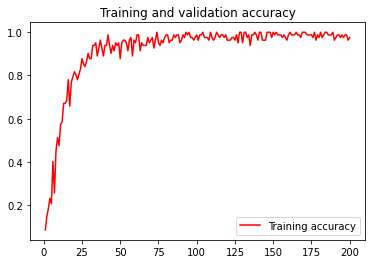

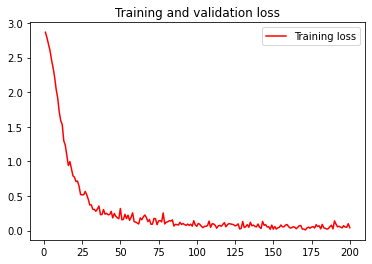

In [53]:
print( hist.history.keys() )

accuracy = hist.history['accuracy']
loss     = hist.history['loss']

plt.plot(epochs, accuracy, 'r-', label='Training accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r-', label='Training loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()